
**Install requirements**

In [ ]:
"""
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
"""

"\n!pip3 install 'torch==1.3.1'\n!pip3 install 'torchvision==0.5.0'\n!pip3 install 'Pillow-SIMD'\n!pip3 install 'tqdm'\n"

**Import libraries**

In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
import numpy as np

import torchvision
from torchvision import transforms
#from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import copy

**Set Arguments**

In [1]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7      # 7 different categories

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.0001            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [3]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      
                                      #transforms.RandomCrop( 64 , padding =2) ,
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

**Prepare Dataset**

In [4]:
#import shutil
#shutil.rmtree('./pacs', ignore_errors=True)

# Clone github repository with data
if not os.path.isdir('./pacs'):
  !git clone https://github.com/lindaludovisi/ellelle-pacs
  !mv 'ellelle-pacs' 'pacs'


DATA_DIR = 'pacs'
DATA_DIR_PHOTO = 'pacs/PACS/photo'
DATA_DIR_ART = 'pacs/PACS/art_painting'
DATA_DIR_CARTOON = 'pacs/PACS/cartoon'
DATA_DIR_SKETCH = 'pacs/PACS/sketch'

# Prepare Pytorch train/test Datasets
source_dataset = torchvision.datasets.ImageFolder(DATA_DIR_PHOTO , transform=train_transform)
target_dataset = torchvision.datasets.ImageFolder(DATA_DIR_ART, transform=eval_transform)

cartoon_dataset = torchvision.datasets.ImageFolder(DATA_DIR_CARTOON, transform=eval_transform)
sketch_dataset = torchvision.datasets.ImageFolder(DATA_DIR_SKETCH, transform=eval_transform)

#train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
#test_indexes = [idx for idx in range(len(test_dataset)) if not idx % 5]

#train_dataset = Subset(train_dataset, train_indexes)
#test_dataset = Subset(test_dataset, test_indexes)

# Check dataset sizes
print('source Dataset: {}'.format(len(source_dataset)))
print('target Dataset: {}'.format(len(target_dataset)))
print('cartoon Dataset: {}'.format(len(cartoon_dataset)))
print('sketch Dataset: {}'.format(len(sketch_dataset)))

Cloning into 'ellelle-pacs'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 10065 (delta 20), reused 0 (delta 0), pack-reused 10032
Receiving objects: 100% (10065/10065), 174.14 MiB | 21.27 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Checking out files: 100% (9994/9994), done.
source Dataset: 1670
target Dataset: 2048
cartoon Dataset: 2344
sketch Dataset: 3929


**Prepare Dataloaders**

In [5]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
source_dataloader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

cartoon_dataloader = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last = True)
sketch_dataloader = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last = True)

**Prepare Network**

In [6]:
from pacs.alexnet import alexnet #alexnet is a function in alexnet.py
net = alexnet(pretrained=True) # Loading AlexNet model

# We need 7 outputs for PACS dataset
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

# Copy weights of the original classifier into the new classifier
for index in [1, 4, 6] :
  net.domain_classifier[index].weight.data = copy.deepcopy(net.classifier[index].weight.data)
  net.domain_classifier[index].bias.data = copy.deepcopy(net.classifier[index].bias.data)

# Print the model we just instantiated
print(net)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


**Prepare Training**

In [7]:
# Define loss function
criterion_class = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
criterion_domain = nn.CrossEntropyLoss()

# Choose parameters to optimize
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [8]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime
#print(f"source len is {len(source_dataloader)}")
#print(f"target len is {len(target_dataloader)}")
#len_dataloader = min(len(source_dataloader), len(target_dataloader))

alpha = 0.1
history = []
current_step = 0
best_acc = 0



# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterator for source data
  data_source_iter = iter(source_dataloader)

  # keep track of loss each epoch
  s_label_loss = 0.0
  s_domain_loss = 0.0
  t_domain_loss = 0.0
  
  """
    TRAINING
  """
  # Iterate over the dataset
  for t_img, _ in target_dataloader:

    net.train() # Sets module in training mode
    
    try:
        data_source = next(data_source_iter)
    except:
        data_source_iter = iter(source_dataloader)
        data_source = next(data_source_iter)
        
    # Source image and source label (category)
    s_img, s_label = data_source


    # Domain label of source data is 0
    s_domain = torch.zeros(BATCH_SIZE)
    s_domain = s_domain.long()

    # Bring data over the device of choice
    s_img = s_img.to(DEVICE)
    s_label = s_label.to(DEVICE)
    s_domain = s_domain.to(DEVICE)

    # Zero-ing the gradients
    optimizer.zero_grad() 

    """
    FIRST STEP : train on source labels by forwarding source data on Gy
    """

    # Forward pass to the network (Gy) with source data
    outputs_s_class = net(s_img)

    # Compute loss based on output and ground truth
    loss_s_label = criterion_class(outputs_s_class, s_label)

    # Multiply average loss times the number of examples in batch
    s_label_loss += loss_s_label.item() * s_img.size(0)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss on source data categories {}'.format(current_step, loss_s_label.item()))

    # Compute gradients for each layer 
    loss_s_label.backward() 

   

    """
      SECOND STEP: train the discriminator by forwarding source data on Gd
    """

    # Forward pass to the network (Gd) with source data
    outputs_s_domain = net(s_img, alpha)
    
    # Compute loss based on output and ground truth
    loss_s_domain = criterion_domain(outputs_s_domain, s_domain)

    # Multiply average loss times the number of examples in batch
    s_domain_loss += loss_s_domain.item() * s_img.size(0)


    # Compute gradients for each layer 
    loss_s_domain.backward()

    

    """
      THIRD STEP: train the discriminator by forwarding target data to Gd
    """

    # Domain label of target data is 1
    t_domain = torch.ones(BATCH_SIZE)
    t_domain = t_domain.long()

    # Bring data over the device of choice
    t_img = t_img.to(DEVICE)
    t_domain = t_domain.to(DEVICE)

    # Forward pass to the network (Gd) with target data
    outputs_t_domain = net(t_img, alpha)
    
    # Compute loss based on output and ground truth
    loss_t_domain = criterion_domain(outputs_t_domain, t_domain) 

    # Multiply average loss times the number of examples in batch
    t_domain_loss += loss_t_domain.item() * t_img.size(0)


    # Compute gradients for each layer 
    loss_t_domain.backward()
    

    optimizer.step() # AT THE END: update weights based on accumulated gradients
    current_step += 1


  # Calculate average losses
  s_label_loss = s_label_loss / len(source_dataloader.dataset)
  s_domain_loss = s_domain_loss / len(source_dataloader.dataset)
  t_domain_loss = t_domain_loss / len(target_dataloader.dataset)
  
  #Save train and validation loss
  history.append([s_label_loss, s_domain_loss, t_domain_loss])

  # Step the scheduler
  scheduler.step() 


Starting epoch 1/30, LR = [0.0001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss on source data categories 1.9290968179702759
Starting epoch 2/30, LR = [0.0001]
Step 10, Loss on source data categories 1.2713254690170288
Starting epoch 3/30, LR = [0.0001]
Step 20, Loss on source data categories 0.7656893730163574
Starting epoch 4/30, LR = [0.0001]
Step 30, Loss on source data categories 0.5803825259208679
Starting epoch 5/30, LR = [0.0001]
Starting epoch 6/30, LR = [0.0001]
Step 40, Loss on source data categories 0.34439143538475037
Starting epoch 7/30, LR = [0.0001]
Step 50, Loss on source data categories 0.3233858346939087
Starting epoch 8/30, LR = [0.0001]
Step 60, Loss on source data categories 0.2595948576927185
Starting epoch 9/30, LR = [0.0001]
Step 70, Loss on source data categories 0.26411503553390503
Starting epoch 10/30, LR = [0.0001]
Starting epoch 11/30, LR = [0.0001]
Step 80, Loss on source data categories 0.2946167588233948
Starting epoch 12/30, LR = [0.0001]
Step 90, Loss on source data categories 0.25510889291763306
Starting epoch 13/30

In [9]:
"""TRAIN WITHOUT DANN"""
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime
#print(f"source len is {len(source_dataloader)}")
#print(f"target len is {len(target_dataloader)}")
#len_dataloader = min(len(source_dataloader), len(target_dataloader))

history = []
current_step = 0
best_acc = 0

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    # keep track of loss each epoch
    s_label_loss = 0.0

    # Iterate over the dataset
    for s_img, s_label in source_dataloader:

        net.train() # Sets module in training mode

        # Bring data over the device of choice
        s_img = s_img.to(DEVICE)
        s_label = s_label.to(DEVICE)

        # Zero-ing the gradients
        optimizer.zero_grad() 

        # Forward pass to the network (Gy) with source data
        outputs_s_class = net(s_img)

        # Compute loss based on output and ground truth
        loss_s_label = criterion_class(outputs_s_class, s_label)

        # Multiply average loss times the number of examples in batch
        s_label_loss += loss_s_label.item() * s_img.size(0)

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss on source data categories {}'.format(current_step, loss_s_label.item()))

        # Compute gradients for each layer 
        loss_s_label.backward() 

        optimizer.step() # AT THE END: update weights based on accumulated gradients
        current_step += 1

    # Calculate average losses
    s_label_loss = s_label_loss / len(source_dataloader.dataset)
    
    #Save train loss
    history.append([s_label_loss])

    # Step the scheduler
    scheduler.step() 




Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


KeyboardInterrupt: ignored

**Test**

100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Test Accuracy: 0.4814453125


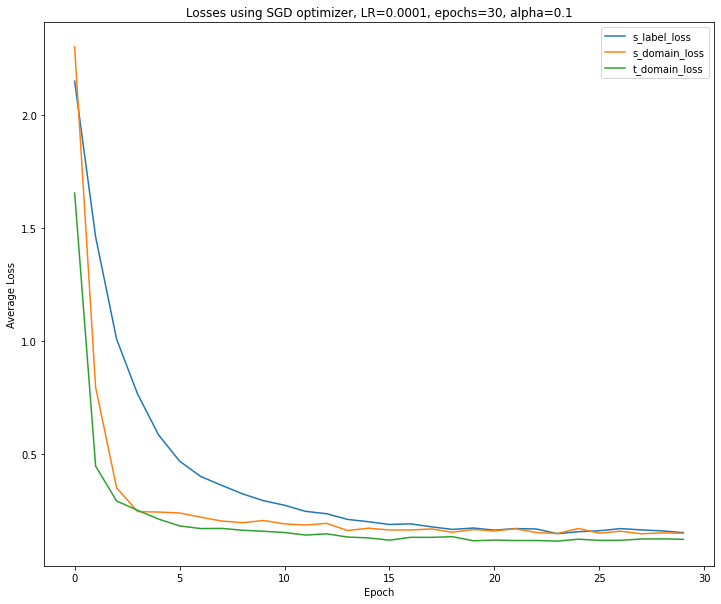

"\n#Plot the source loss\nplt.figure(figsize=(8,6))\nplt.plot(history['s_label_loss'], label='source_loss')\nplt.legend()\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.title(f'Train Loss using SGD optimizer, LR={LR}, epochs={NUM_EPOCHS}, alpha={alpha}')\nplt.show()\n"

In [10]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(target_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(target_dataset))

print('Test Accuracy: {}'.format(accuracy))

import pandas as pd
import matplotlib.pyplot as plt

# History is a Dataframe
history = pd.DataFrame( history, columns=['s_label_loss' , 's_domain_loss', 't_domain_loss'])
#history = pd.DataFrame( history, columns=['s_label_loss'])


# Plot the obtained losses
plt.figure(figsize=(12, 10))
for c in ['s_label_loss', 's_domain_loss', 't_domain_loss']:
  plt.plot(history[c], label=c)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title(f'Losses using SGD optimizer, LR={LR}, epochs={NUM_EPOCHS}, alpha={alpha}')
plt.show()

'''
#Plot the source loss
plt.figure(figsize=(8,6))
plt.plot(history['s_label_loss'], label='source_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Train Loss using SGD optimizer, LR={LR}, epochs={NUM_EPOCHS}, alpha={alpha}')
plt.show()
'''